# Learning to regress polynomial time series<br/>using a dense network
#### This is a Python3 notebook

In [11]:
import numpy as np
from numpy.lib.stride_tricks import as_strided
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
Sequential = keras.models.Sequential
Dense = keras.layers.Dense

In [2]:
window_size = 10
hidden_size = 20
seq_length = 100
n_train = 1000
n_test = 1000

In [3]:
def create_model(window_size, hidden_size, display_summary=True):
    """
    seq_length=None: flexible sequence length. recommended for actual usage.
    seq_length=NUMBER: recommended for model summary.
    """
    model = Sequential()
    model.add(Dense(name='window_dense', units=hidden_size, activation='relu',
                    input_shape=(window_size,)))
    model.add(Dense(name='hidden1', units=hidden_size, activation='relu'))
    model.add(Dense(name='hidden2', units=hidden_size, activation='relu'))
    model.add(Dense(name='regressor', units=1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    if display_summary:
        model.summary()
    return model

In [4]:
def generate_polynomial_sequences(seq_length, num_seqs, degree=3, span=2):
    seq = np.zeros((num_seqs, seq_length))
    x = np.linspace(-span, span, seq_length)
    monoms = x[:, np.newaxis] ** range(degree + 1)
    coeffs = np.random.randn(num_seqs, degree + 1)
    polynomes = np.matmul(coeffs, monoms.T)
    return polynomes

In [5]:
def plot_preds(real, predicted, num_plot=5, title=None):
    plt.figure()
    window_size = real.shape[1] - predicted.shape[1]
    plt.axvline(window_size, linestyle=':', color='k')
    x_real = np.arange(real.shape[1])
    x_pred = np.arange(window_size, real.shape[1])
    if title is not None:
        plt.title(title)
    for i_poly in np.random.randint(real.shape[0], size=num_plot):
        color = np.random.rand(3) * 0.75
        plt.plot(x_real, real[i_poly,:], color=color, linewidth=5)
        plt.plot(x_pred, predicted[i_poly,:], '--', color='k')
    plt.show()

In [6]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return as_strided(a, shape=shape, strides=strides).copy()

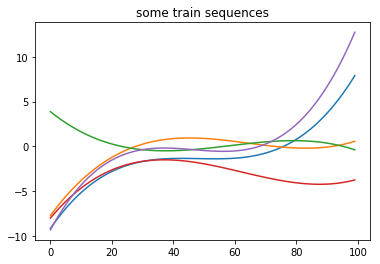

In [7]:
sequences_train = generate_polynomial_sequences(seq_length, n_train)
sequences_test = generate_polynomial_sequences(seq_length, n_test)

windows_train = rolling_window(sequences_train[:, :-1], window_size)
windows_test = rolling_window(sequences_test[:, :-1], window_size)

x_train = windows_train.reshape(-1, window_size)
y_train = sequences_train[:, window_size:].flatten()
x_test = windows_test.reshape(-1, window_size)
y_test = sequences_test[:, window_size:].flatten()

num_plot = 5
plot_inds = np.random.randint(sequences_train.shape[0], size=num_plot)
plt.figure()
plt.title('some train sequences')
plt.plot(sequences_train[plot_inds,:].T)
plt.show()

In [8]:
model = create_model(window_size, hidden_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
window_dense (Dense)         (None, 20)                220       
_________________________________________________________________
hidden1 (Dense)              (None, 20)                420       
_________________________________________________________________
hidden2 (Dense)              (None, 20)                420       
_________________________________________________________________
regressor (Dense)            (None, 1)                 21        
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
_________________________________________________________________


Epoch 1/1
90000/90000 [==============================] - 4s 44us/step - loss: 0.1791


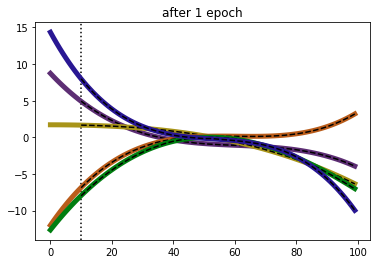

Epoch 1/2
90000/90000 [==============================] - 6s 62us/step - loss: 0.0030
Epoch 2/2
90000/90000 [==============================] - 6s 63us/step - loss: 0.0023


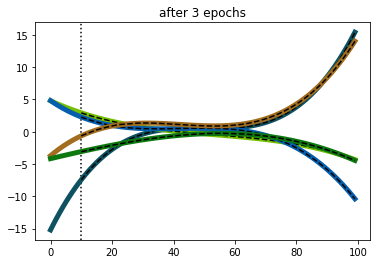

Epoch 1/6
90000/90000 [==============================] - 6s 62us/step - loss: 0.0016
Epoch 2/6
90000/90000 [==============================] - 6s 64us/step - loss: 0.0017
Epoch 3/6
90000/90000 [==============================] - 5s 60us/step - loss: 0.0018
Epoch 4/6
90000/90000 [==============================] - 5s 60us/step - loss: 0.0014
Epoch 5/6
90000/90000 [==============================] - 5s 60us/step - loss: 0.0014
Epoch 6/6
90000/90000 [==============================] - 5s 61us/step - loss: 8.8499e-04


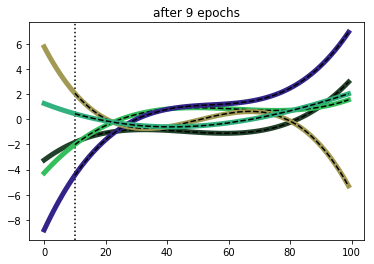


evaluating:

90000/90000 [==============================] - 2s 25us/step
loss_train: 0.0001479849118359425
loss_test: 0.00015622185776369154


In [9]:
model.fit(x_train, y_train, epochs=1)
pred_test = model.predict(x_test).reshape(n_test, -1)
plot_preds(sequences_test, pred_test, title='after 1 epoch')

model.fit(x_train, y_train, epochs=2)
pred_test = model.predict(x_test).reshape(n_test, -1)
plot_preds(sequences_test, pred_test, title='after 3 epochs')

model.fit(x_train, y_train, epochs=6)
pred_test = model.predict(x_test).reshape(n_test, -1)
plot_preds(sequences_test, pred_test, title='after 9 epochs')

print('\nevaluating:\n')
loss_train = model.evaluate(x_train, y_train)
loss_test = model.evaluate(x_test, y_test)
print('loss_train:', loss_train)
print('loss_test:', loss_test)

In [10]:
%timeit model.predict(x_test).reshape(n_test, -1)
%timeit model.predict(x_test).reshape(n_test, -1)
%timeit model.predict(x_test).reshape(n_test, -1)

1.6 s ± 28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.6 s ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.63 s ± 64.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
